# Redes Neuronales
**Diego Díaz Fonseca**

## Paquetes

In [ ]:
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd
import seaborn           as sns
from tqdm                    import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix
from sklearn.preprocessing   import StandardScaler

## Funciones auxiliares

In [ ]:
def sigmoid(x):   return 1/(1 + np.exp(-x))
def d_sigmoid(y): return y*(1-y)
def tanh(x):      return (np.exp(x) -  np.exp(-x)) / (np.exp(x) + np.exp(-x))
def d_tanh(y):    return 1 - y**2 
def relu(x):      return x if x > 0 else 0
def d_relu(y):    return 1 if y > 0 else 0
def lrelu(x):     return x if x > 0 else 0.01*x
def d_lrelu(y):   return 1 if y > 0 else 0.01

def precisiones(confusion_matrix):
  precisiones = []
  for i, number in enumerate(confusion_matrix.diagonal()):
    precisiones.append(number/confusion_matrix[i,:].sum())
  return np.array(precisiones)

def exhaustividades(confusion_matrix):
  exhaustividades = []
  for i, number in enumerate(confusion_matrix.diagonal()):
    exhaustividades.append(number/confusion_matrix[:,i].sum())
  return np.array(exhaustividades)

def F1_scores(precisiones, exhaustividades):
  return 2*precisiones*exhaustividades/(precisiones+exhaustividades)

def imprimir_metrica_por_clase(metrica):
  to_print = ("\tClase " + str(i) + ": " + str(metrica[i]) for i in range(len(metrica)))
  for string in to_print:
    print(string)

## Implementación red neuronal

In [ ]:
class DenseNN:
  def __init__(self, layers, activation, seed=0):
    np.random.seed(seed)
    self.activation_funtions   = list(map(self.__get_activation_function, activation))
    self.d_activation_funtions = list(map(self.__get_d_activation_function, activation))
    self.list_weight_matrices  = []
    self.layers_width  = layers
    self.amount_layers = len(layers)
    for i, layer_witdh in enumerate(self.layers_width[1:], start=1):
      previous_layer_width = self.layers_width[i-1]
      mu, sigma = 0, 2/np.sqrt(previous_layer_width + layer_witdh)
      random_weights = np.random.normal(mu, sigma, (previous_layer_width+1, layer_witdh))

      self.list_weight_matrices.append(random_weights)
    
    self.epoch_counter = 0
    self.valores_netos = []
    self.valores_activacion = []
    self.errores_por_capa   = []
    self.errores_por_capa_anterior = []
    self.lr       = float("inf")
    self.momentum = float("inf")
    self.decay    = float("inf")
    self.n = 1
    self.error_history = []

  def __get_activation_function(self, f):
    if f == 's': return sigmoid
    if f == 't': return tanh
    if f == 'r': return np.vectorize(relu)
    if f == 'l': return np.vectorize(lrelu)

  def __get_d_activation_function(self, f):
    if f == 's': return d_sigmoid
    if f == 't': return d_tanh
    if f == 'r': return np.vectorize(d_relu)
    if f == 'l': return np.vectorize(d_lrelu)

  def predict(self, x):
    self.valores_activacion = []
    self.valores_netos = []
    layer_output = np.hstack([x, np.ones((x.shape[0],1))])
    for i, weight_matrix in enumerate(self.list_weight_matrices):
      layer_output = self.activation_funtions[i](np.matmul(layer_output, weight_matrix))
      if i != len(self.list_weight_matrices)-1:
        layer_output = np.hstack([layer_output, np.ones((layer_output.shape[0],1))])
      self.valores_activacion.append(layer_output)
    
    return pd.DataFrame(layer_output)

  def train(self, lr=0.05, momentum=0, decay=0):
    self.lr = lr
    self.momentum = momentum
    self.decay = decay
    
    self.errores_por_capa = []
    self.errores_por_capa_anterior = []

    for weight_matrix in self.list_weight_matrices:
      self.errores_por_capa.append(np.zeros_like(weight_matrix))
      self.errores_por_capa_anterior.append(np.zeros_like(weight_matrix))

    self.epoch_counter = 0

  def backpropagation(self, x, y):
    self.n = x.shape[0]
    prediction = np.asarray(self.predict(x))
    x = np.hstack([x, np.ones((x.shape[0],1))])
    for i in reversed(range(len(self.errores_por_capa))):
      if i == len(self.errores_por_capa)-1:
        error_siguiente_capa = 2 * (prediction - y) * self.d_activation_funtions[-1](self.valores_activacion[-1])
        self.error_history.append((error_siguiente_capa**2).sum())
      else:
        totalError           = self.d_activation_funtions[i](self.valores_activacion[i])
        errorPonderado       = np.matmul(error_i_mas_1, self.list_weight_matrices[i+1].T)
        error_capa_oculta    = errorPonderado * totalError
        error_siguiente_capa = np.delete(error_capa_oculta, error_capa_oculta.shape[1]-1, axis=1)
      
      error_i_mas_1 = error_siguiente_capa
      if i > 0:
        self.errores_por_capa[i] += np.matmul(self.valores_activacion[i-1].T, error_siguiente_capa)
      else:
        self.errores_por_capa[i] += np.matmul(x.T, error_siguiente_capa)

  def step(self):
    for i, weight_matrix in enumerate(self.list_weight_matrices):
      change = self.lr * (self.errores_por_capa[i] + self.momentum * self.errores_por_capa_anterior[i])
      self.list_weight_matrices[i] = weight_matrix - change
    
    # almaceno los errores viejos
    for i, error_matrix in enumerate(self.errores_por_capa):
      self.errores_por_capa_anterior[i] = np.copy(error_matrix)
    
    # creo los nuevos errores con ceros
    self.errores_por_capa = []
    for weight_matrix in self.list_weight_matrices:
      self.errores_por_capa.append(np.zeros_like(weight_matrix))

    self.lr *= 1/(1+self.decay)
    self.epoch_counter += 1

  def plot_error_metric(self, log=True):
    plt.plot(self.error_history)
    if log:
      plt.xscale("log")
      plt.yscale("log")
    plt.title('Error durante el entrenamiento')
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.show()

## Pruebas

### Traer la información

In [ ]:
def get_data():
  dataFrame = pd.read_csv("titanic.csv")
  dataFrame.drop(['PassengerId','Name','Ticket','Cabin'], inplace=True, axis=1)
  dataFrame.dropna(inplace = True)
  return pd.get_dummies(dataFrame,columns=["Embarked", 'Sex', 'Pclass','Survived'])

In [ ]:
data_unscaled = get_data()
data_unscaled.head()

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Survived_0,Survived_1
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1,1,0
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0,0,1
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1,0,1
3,35.0,1,0,53.1000,0,0,1,1,0,1,0,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1,1,0


In [ ]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data_unscaled))
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.544119,0.543133,-0.502064,-0.526730,-0.505088,-0.224394,0.579195,-0.766498,0.766498,-0.608741,-0.577719,1.042113,0.812913,-0.812913
1,0.570136,0.543133,-0.502064,0.622325,1.979851,-0.224394,-1.726533,1.304635,-1.304635,1.642736,-0.577719,-0.959589,-1.230143,1.230143
2,-0.265555,-0.552587,-0.502064,-0.514617,-0.505088,-0.224394,0.579195,1.304635,-1.304635,-0.608741,-0.577719,1.042113,-1.230143,1.230143
3,0.361214,0.543133,-0.502064,0.296032,-0.505088,-0.224394,0.579195,1.304635,-1.304635,1.642736,-0.577719,-0.959589,-1.230143,1.230143
4,0.361214,-0.552587,-0.502064,-0.512374,-0.505088,-0.224394,0.579195,-0.766498,0.766498,-0.608741,-0.577719,1.042113,0.812913,-0.812913


### Separar el conjunto de datos

In [ ]:
X = data.iloc[:,list(range(12))]
y = data.iloc[:,[12,13]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=616)

### Entrenamiento

In [ ]:
# ‘s’: sigmoide, ‘t’: tangente hiperbólico, ‘r’: relu y ‘l’: leaky-relu
NN = DenseNN([12,4,2],"ls")
NN.train(lr=1e-4, momentum=1e-6, decay=1e-10)
for i in tqdm(range(int(1e4+1e3))):
  NN.backpropagation(np.asarray(X_train), np.asarray(y_train))
  NN.step()

100%|██████████| 11000/11000 [00:23<00:00, 469.63it/s]


### Evaluación

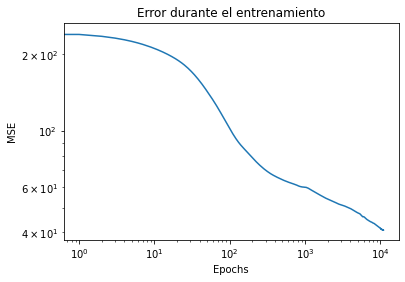

In [ ]:
NN.plot_error_metric(log=True)

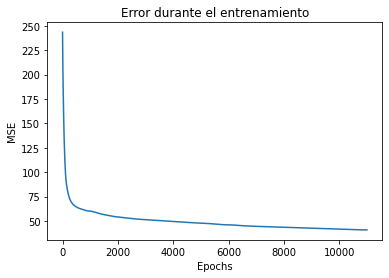

In [ ]:
NN.plot_error_metric(log=False)

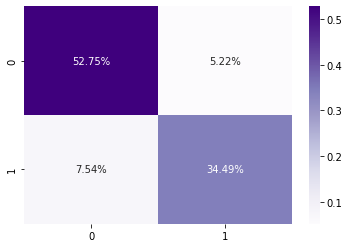

In [ ]:
p = NN.predict(X_test)
results = p.apply(np.argmax, axis=1)
CM = confusion_matrix(y_test.apply(np.argmax, axis=1), results)
sns.heatmap(CM/np.sum(CM), annot=True, fmt='.2%', cmap='Purples')

In [ ]:
prec = precisiones(CM)
print("Precisiones:")
imprimir_metrica_por_clase(prec)

exhaus = exhaustividades(CM)
print("Exhaustividades:")
imprimir_metrica_por_clase(exhaus)

f1 = F1_scores(prec, exhaus)
print("F1_scores:")
imprimir_metrica_por_clase(f1)

Precisiones:
	Clase 0: 0.91
	Clase 1: 0.8206896551724138
Exhaustividades:
	Clase 0: 0.875
	Clase 1: 0.8686131386861314
F1_scores:
	Clase 0: 0.892156862745098
	Clase 1: 0.8439716312056738
